In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
from tqdm import tqdm
import numpy as np
import pickle
import json
import random
import copy
from collections import defaultdict
import itertools
import multiprocessing
from collections import Counter
from functools import partial
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from value_probes import *
from utils import binomial_confidence_interval

## Load validation features

In [4]:
def load_activations(seed):
    feature_train = []
    label_train = []

    with open(f"features/llama7b_sft_seed{seed}_res_layer32.npy", "rb") as f:
        features = np.load(f)
        features = features.reshape(features.shape[0], -1)
        feature_train.append(features)

    programs, gt_labels = [], []
    samples = json.load(open(f"samples/llama7b_sft_seed{seed}.json"))["samples"]  # a list of dict with keys ['prompt', 'chosen', 'policy', 'winner']

    for sample in samples:
        policy = sample["prompt"] + sample["policy"]
        programs.append(policy.rstrip())
        if sample["winner"] == "policy":
            gt_labels.append(1)
        elif sample["winner"] == "chosen":
            gt_labels.append(0)
        else:
            gt_labels.append(-1)

    feature_train = np.concatenate(feature_train, axis=0)
    feature_train = feature_train[::2, None, :]
    # print(feature_train.shape)
    label_train = np.array(gt_labels)
    # print(label_train.shape)
    return feature_train, label_train

In [5]:
feature_vals = []
label_vals = []
for seed in tqdm(range(1, 49)):
    feature_val, label_val = load_activations(seed)
    feature_vals.append(feature_val)
    label_vals.append(label_val)
feature_val = np.concatenate(feature_vals, axis=1)
label_val = np.stack(label_vals, axis=-1)
print(feature_val.shape)
print(label_val.shape)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 126.32it/s]


(512, 48, 4096)
(512, 48)


## load training features

In [6]:
def load_activations(part, layer, exp_name):
    feature_train = []
    label_train = []

    with open(f"features/{exp_name}_part{part}of16_res_layer{layer}.npy", "rb") as f:
        features = np.load(f)
        features = features.reshape(features.shape[0], -1)
        feature_train.append(features)

    programs, gt_labels = [], []
    samples = json.load(open(f"samples/{exp_name}.json"))["samples"]  # a list of dict with keys ['prompt', 'chosen', 'policy', 'winner']

    for sample in samples:
        policy = sample["prompt"] + sample["policy"]
        programs.append(policy.rstrip())
        gt_labels.append(1 if sample["winner"] == "policy" else 0)
        chosen = sample["prompt"] + sample["chosen"]
        programs.append(chosen.rstrip())
        gt_labels.append(1 if sample["winner"] == "chosen" else 0)

    start_idx = len(programs) // 16 * part
    if part == 16 - 1:
        end_idx = len(programs)
    else:
        end_idx = len(programs) // 16 * (part + 1)

    feature_train = np.concatenate(feature_train, axis=0)
    feature_train = np.concatenate([feature_train[::2, None, :], feature_train[1::2, None, :]], axis=1)
    # print(feature_train.shape)
    label_train = np.array(gt_labels[start_idx:end_idx][1::2])
    # print(label_train.shape)
    return feature_train, label_train

In [7]:
exp_name = "train_extraction"
# load from multiple parts
layer = 32
feature_trains = []
label_trains = []
for part in tqdm(range(16)):
    feature_train, label_train = load_activations(part, layer, exp_name)
    feature_trains.append(feature_train)
    label_trains.append(label_train)
feature_train_all = np.concatenate(feature_trains, axis=0)
label_train_all = np.concatenate(label_trains, axis=0)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


In [8]:
np.random.seed(0)
idx = np.random.choice(len(label_train_all), int(len(label_train_all) * .2), replace=False)
feature_train = feature_train_all[idx]
label_train = label_train_all[idx]
print(feature_train.shape)
print(label_train.shape)

(40067, 2, 4096)
(40067,)


## Train a probe on training set

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/pfister_lab2/Lab/like/anaconda3/envs/halos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/pfister_lab2/Lab/like/anaconda3/envs/halos/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Training probe, validation accuracy now = 60.93%, train accuracy = 60.93%: 100%|██████████| 150/150 [00:05<00:00, 27.35it/s]


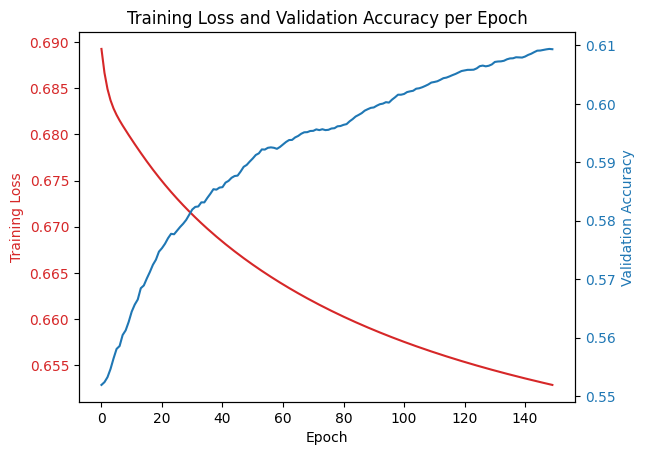

In [9]:
if 'value_obj' in globals():
    del value_obj
value_obj = ProbeTrainer(
    feature_train, 
    label_train, 
    loss='ce', 
    tr_pctg=1.0, 
    batch_size=1024,
    layer=1, 
    lr=5e-5, 
    num_epochs=150,
    weight_decay=0., 
)
acc_bucket, loss_bucket = value_obj.train()

fig, ax1 = plt.subplots()

# Plotting the training loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='tab:red')
ax1.plot(loss_bucket, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Creating another axis for validation accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Validation Accuracy', color='tab:blue') 
ax2.plot(acc_bucket, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Displaying the plot
plt.title('Training Loss and Validation Accuracy per Epoch')
plt.show()

Before, the winrate is 38.08%
After, the winrate is 50.88%
An oracle probe would yield a winrate of 91.59%


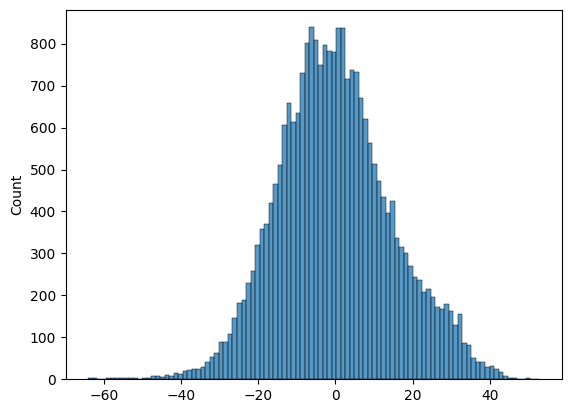

In [10]:
feature_vals_tensor = torch.tensor(feature_val).float().cuda()
value_hats = value_obj.probe(feature_vals_tensor).detach().cpu().numpy()
sns.histplot(value_hats.flatten(), bins=100)
curated_values = value_hats
masked_value_hats = np.ma.array(curated_values, mask=label_val == -1)
chosen_vals = np.argmax(masked_value_hats, axis=1)
rewards = label_val[np.arange(label_val.shape[0]), chosen_vals]
new_reward = np.sum(rewards == 1).item() / np.sum(rewards >= 0).item()
old_reward = np.sum(label_val == 1).item() / np.sum(label_val >= 0).item()
max_rewards = np.max(label_val, axis=-1)
max_reward = np.sum(max_rewards == 1).item() / np.sum(max_rewards >= 0).item()
print(f"Before, the winrate is {old_reward * 100:.2f}%")
print(f"After, the winrate is {new_reward * 100:.2f}%")
print(f"An oracle probe would yield a winrate of {max_reward * 100:.2f}%")
plt.show()

# Sweeping K

In [11]:
print(masked_value_hats.shape)
print(label_val.shape)

(512, 48)
(512, 48)


In [12]:
res_list = []
for k in range(2, 49):
    for seed in range(10):
        np.random.seed(seed)
        idx = np.random.choice(48, k, replace=False)
        selected_masked_value_hats = masked_value_hats[:, idx]
        selected_label_val = label_val[:, idx]
        max_rewards = np.max(selected_label_val, axis=-1)
        max_reward = np.sum(max_rewards == 1).item() / np.sum(max_rewards >= 0).item()
        chosen_vals = np.argmax(selected_masked_value_hats, axis=1)
        rewards = selected_label_val[np.arange(selected_label_val.shape[0]), chosen_vals]
        new_reward = np.sum(rewards == 1).item() / np.sum(rewards >= 0).item()
        res_list.append(dict(seed=seed, k=k, type="Q-softmax", value=new_reward))
        res_list.append(dict(seed=seed, k=k, type="Skyline", value=max_reward))
res_list.append(dict(seed=0, k=1, type="Q-softmax", value=np.sum(label_val == 1).item() / np.sum(label_val >= 0).item()))
res_list.append(dict(seed=0, k=1, type="Skyline", value=np.sum(label_val == 1).item() / np.sum(label_val >= 0).item()))
df = pd.DataFrame(res_list)
df.head(12)

,seed,k,type,value
0,0,2,Q-softmax,0.441955
1,0,2,Skyline,0.543788
2,1,2,Q-softmax,0.432049
3,1,2,Skyline,0.533469
4,2,2,Q-softmax,0.404427
5,2,2,Skyline,0.511066
6,3,2,Q-softmax,0.421907
7,3,2,Skyline,0.545639
8,4,2,Q-softmax,0.416162
9,4,2,Skyline,0.519192


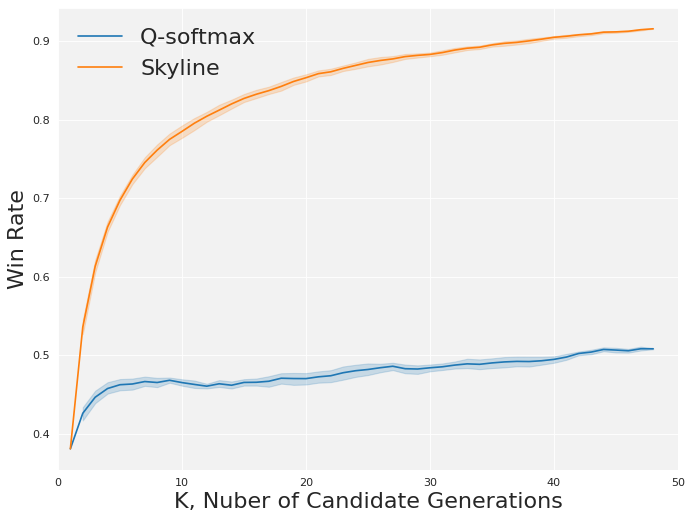

In [13]:
fs = 20
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

sns.lineplot(data=df, x="k", y="value", hue="type", errorbar=('ci', 95), ax=ax)
ax.set_xlim(right=50, left=0)
ax.set_xlabel("K, Nuber of Candidate Generations", fontsize=fs)
ax.set_ylabel("Win Rate", fontsize=fs)
ax.legend(bbox_to_anchor=(0., 1), loc='upper left', frameon=False)
plt.show()